In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

In [70]:
warnings.filterwarnings('ignore')

In [71]:
def myPCA(A):
    cov_matrix = np.cov(A.T)
    eigenvals, eigenvecs = np.linalg.eig(cov_matrix)
    idx = np.argsort(eigenvals)[::-1]
    return eigenvecs[:, idx], eigenvals[idx]

In [72]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [73]:
delay_data = pd.read_csv('./data/delay_7_9_CONDITION_PRODUCT_SUPPLIER.csv')
delay_data

,Order date,SUBSIDIARY_CD,GLOBAL_NO,CLASSIFY_CD,CUST_CD,BRAND_CD,INNER_CD,SUPPLIER_CD,Sales order line number,Stock class,Consider count hodiday Saturday,SO QTY,OTHER AREA SHIP DIV,ALLOCATION QTY,SUPPLIER INV AMOUNT,PACKING RANK,PRODUCT_CD,PRODUCT ATTRIBUTION,SPECIAL DIV,LOGICAL PLANT,PURCHASE AMOUNT,VSD,DIRECT SHIP FLG,DELI_DIV,label,Ship Mode,SHIP DECISION NO,PACK QTY,WEIGHT PER PIECE,SUPPLIER_DIV,SPECIAL_DIV,SO_DAY_OF_MONTH,SO_DAY_OF_WEEK,REASON_CD,SOUF_RCV_NO,QTUF_RCV_NO,SO_TIME
0,2022-08-25,MJP,08344472000137,21031103,344472,OSA1,F7171260007,8121,8,1,4,1,1.0,1,13240.0,Z,EL-2C-304-3.5S,1,0,52,13240.0,2022-11-01,0,00,1,C,NaN,0,1020,2.0,0,25,4,453.0,NaN,NaN,135557
1,2022-08-12,MJP,06000641365551,3712333,641,MSM1,30071630003,0263,1,1,0,2,NaN,2,1532.0,A,MLSTN15-10,1,0,53,1532.0,2022-08-26,1,50,1,T,166104.0,0,120,1.0,0,12,5,451.0,NaN,NaN,134532
2,2022-07-08,MJP,07032167936864,21045918,32167,SMC1,F7499483132,9102,1,1,4,1,1.0,1,45710.0,B,CDA2L80-1600Z,1,0,55,45710.0,2022-09-15,0,00,1,Q,461869.0,0,18000,3.0,0,8,5,410.0,NaN,NaN,160936
3,2022-07-08,MJP,01710046000973,21058302,710046,MIB1,F4524160001,9163,1,1,4,2,NaN,2,4546.0,Z,BSTRODNA-45-1000,1,0,53,4546.0,2023-01-20,0,00,1,B,NaN,0,500,2.0,0,8,5,453.0,NaN,NaN,160702
4,2022-08-25,MJP,07107539916817,21050569,107539,NIQ1,F3017310155,9176,6,1,4,2,NaN,2,158.0,Z,AFS-2060-4-80,1,0,55,158.0,2022-10-03,1,50,1,R,508041.0,0,36,2.0,0,25,4,455.0,NaN,NaN,160244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26212,2022-07-27,MJP,KAW06CCI000005,21020310,147666,UNT1,F3016410297,8107,1,1,4,5,NaN,5,725.0,Z,405-1.5GT-2,1,1,53,725.0,2022-08-11,0,00,1,P,34435.0,0,100,3.0,1,27,3,NaN,NaN,NaN,84245
26213,2022-07-27,MJP,GC00HIAI002754,23027680,251577,TRC1,K8014170003,8484,2,1,4,13,NaN,13,15730.0,Z,TWB16-2150,1,1,53,15730.0,2022-08-03,0,00,1,P,230847.0,10,315,3.0,1,27,3,401.0,NaN,NaN,190113
26214,2022-07-27,MJP,GA00MTLM000244,3721101,251577,MSM1,30016660009,3764,1,1,0,60,NaN,60,20580.0,Z,FSFJBA-D8-L69-M5,1,1,53,20580.0,2022-08-11,0,00,1,P,35075.0,0,28,1.0,1,27,3,NaN,NaN,NaN,195137
26215,2022-08-19,MJP,CAW02AW3000626,6050902,254252,MSM1,62700021018,1029,6,0,4,2,NaN,2,8180.0,Z,DIAPC-10-15000,0,1,53,8180.0,2022-09-02,0,00,1,P,203089.0,0,40,2.0,1,19,5,401.0,NaN,NaN,160258


# Phần 1: Principal Component Analysis

In [74]:
df_processed = delay_data.copy()

In [75]:
threshold = 0.95

missing_ratio = df_processed.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > threshold].index
df_processed.drop(columns=cols_to_drop, inplace=True)

In [76]:
categorical_cols = df_processed.select_dtypes(include=['object']).columns

label_encoders = {}

for col in categorical_cols:
    df_processed[col] = df_processed[col].astype(str)
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

In [77]:
for col in df_processed.columns:
    if df_processed[col].dtype in [np.float64, np.int64]:
        df_processed[col].fillna(df_processed[col].mean(), inplace=True)
    else:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

In [78]:
X = df_processed.drop(columns=['label']).to_numpy()

In [79]:
X

array([[4.70000000e+01, 0.00000000e+00, 1.56500000e+04, ...,
        4.00000000e+00, 4.53000000e+02, 1.35557000e+05],
       [3.60000000e+01, 0.00000000e+00, 6.06100000e+03, ...,
        5.00000000e+00, 4.51000000e+02, 1.34532000e+05],
       [6.00000000e+00, 0.00000000e+00, 7.34700000e+03, ...,
        5.00000000e+00, 4.10000000e+02, 1.60936000e+05],
       ...,
       [2.20000000e+01, 0.00000000e+00, 2.24300000e+04, ...,
        3.00000000e+00, 4.13388704e+02, 1.95137000e+05],
       [4.20000000e+01, 0.00000000e+00, 2.18780000e+04, ...,
        5.00000000e+00, 4.01000000e+02, 1.60258000e+05],
       [6.60000000e+01, 0.00000000e+00, 2.18900000e+04, ...,
        5.00000000e+00, 4.51000000e+02, 1.81626000e+05]])

In [80]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [81]:
eigenvecs, eigenvals = myPCA(X_scaled)
X_pca = X_scaled @ eigenvecs

## Tính PC1 (Thành phần chính thứ nhất) và PC2 (Thành phần chính thứ hai)

In [82]:
PC1 = X_pca[:, 0]
PC2 = X_pca[:, 1]

## Áp dụng KMeans lên PC1

In [83]:
PC1_reshaped = PC1.reshape(-1, 1)
kmeans_pc1 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_pc1 = kmeans_pc1.fit_predict(PC1_reshaped)

## Áp dụng KMeans lên PC2

In [84]:
PC2_reshaped = PC2.reshape(-1, 1)
kmeans_pc2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_pc2 = kmeans_pc2.fit_predict(PC2_reshaped)

## Áp dụng KMeans lên tập dữ liệu sau khi đã chuẩn hóa (X_scaled)

In [85]:
kmeans_raw = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_raw = kmeans_raw.fit_predict(X_scaled)


sil_score_raw = silhouette_score(X_scaled, labels_raw)
sil_score_pc1 = silhouette_score(PC1_reshaped, labels_pc1)
sil_score_pc2 = silhouette_score(PC2_reshaped, labels_pc2)

In [86]:
silhouette_results = pd.DataFrame({
    "Phân cụm": ["KMeans trên dữ liệu gốc", "KMeans trên PC1", "KMeans trên PC2"],
    "Silhouette Score": [sil_score_raw, sil_score_pc1, sil_score_pc2]
})

silhouette_results

,Phân cụm,Silhouette Score
0,KMeans trên dữ liệu gốc,0.257919
1,KMeans trên PC1,0.768981
2,KMeans trên PC2,0.898497


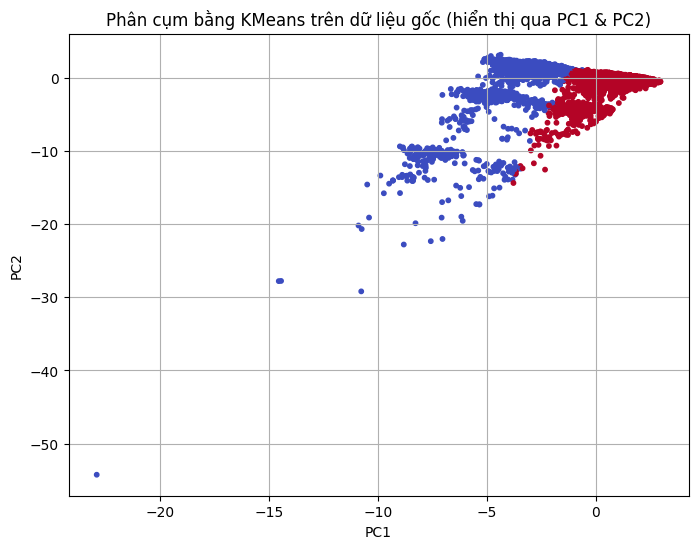

In [87]:
plt.figure(figsize=(8,6))
plt.scatter(PC1, PC2, c=labels_raw, cmap='coolwarm', s=10)
plt.title("Phân cụm bằng KMeans trên dữ liệu gốc (hiển thị qua PC1 & PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## Biểu đồ phương sai tích lũy

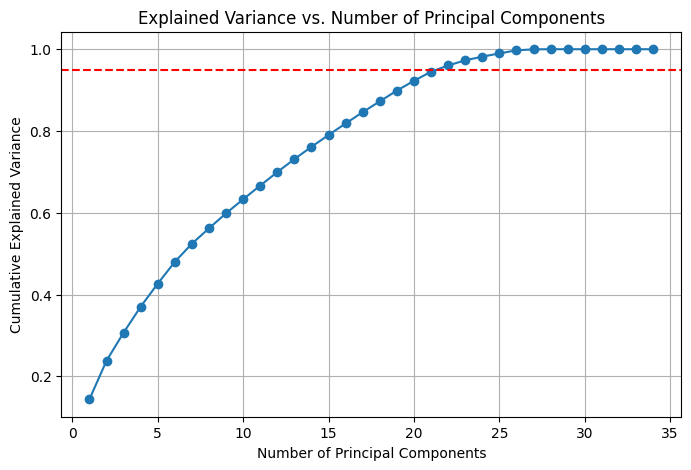

In [88]:
explained_variance = eigenvals / np.sum(eigenvals)
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Principal Components")
plt.grid(True)
plt.show()

## Câu hỏi lý thuyết

# Phần 2: Phân cụm dữ liệu (Clustering)

In [89]:
from sklearn.metrics import pairwise_distances_argmin

In [90]:
X_scaled

array([[ 0.64781761,  0.        ,  0.33587925, ...,  0.57390508,
         0.98562779, -0.03995309],
       [ 0.13816266,  0.        , -0.93113339, ...,  1.24095905,
         0.93586281, -0.07156091],
       [-1.25180539,  0.        , -0.76121179, ...,  1.24095905,
        -0.0843194 ,  0.74265667],
       ...,
       [-0.5104891 ,  0.        ,  1.23173343, ..., -0.0931489 ,
         0.        ,  1.79730959],
       [ 0.41615627,  0.        ,  1.15879663, ...,  1.24095905,
        -0.30826184,  0.72174925],
       [ 1.52813071,  0.        ,  1.16038221, ...,  1.24095905,
         0.93586281,  1.3806722 ]])

## Hàm myKmeans from scratch

In [91]:
def myKmeans(A, num_clusters):
    np.random.seed(42)

    initial_idx = np.random.choice(len(A), num_clusters, replace=False)
    centroids = A[initial_idx]

    for _ in range(100):
        clusters = pairwise_distances_argmin(A, centroids)
        new_centroids = np.array([A[clusters==i].mean(axis=0) for i in range(num_clusters)])  
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return clusters, centroids

## Các tham số đầu vào cho KMeans trong Sklearn

In [92]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(_BaseKMeans)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
 |
 |  K-Means clustering.
 |
 |  Read more in the :ref:`User Guide <k_means>`.
 |
 |  Parameters
 |  ----------
 |
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |
 |      For an example of how to choose an optimal value for `n_clusters` refer to
 |      :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.
 |
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |
 |      * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to the overall ine

## Áp dụng sklearn.KMeans với `k = 2`

In [93]:
kmeans_sk = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_sk = kmeans_sk.fit_predict(X_scaled)
centroids_sk = kmeans_sk.cluster_centers_

## Áp dụng myKMeans với `k=2`

In [94]:
labels_my, centroids_my = myKmeans(X_scaled, 2)

## Sự khác biệt giữa 2 cách triển khai

In [95]:
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(centroids_my, centroids_sk)

In [96]:
print('Khoảng cách giữa các tâm cụm của hai cách triển khai (Sklearn và myKMeans)')
print(distance_matrix)

Khoảng cách giữa các tâm cụm của hai cách triển khai (Sklearn và myKMeans)
[[2.35160477e-03 4.55443552e+00]
 [4.55488953e+00 8.13657845e-04]]


## Sử dụng Elbow để lựa chọn số K tối ưu

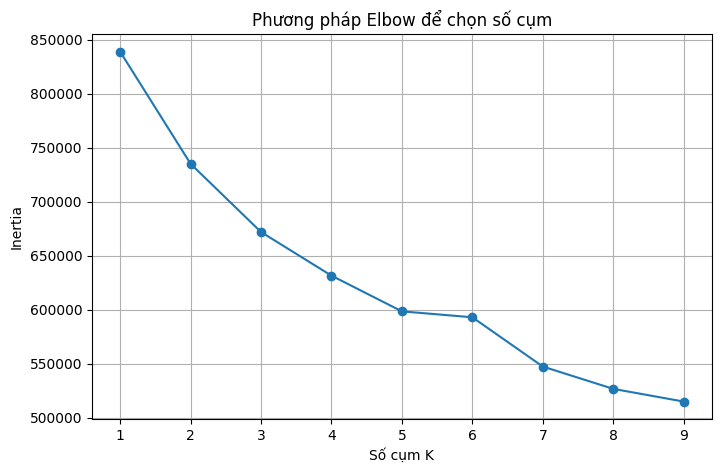

In [97]:
inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Số cụm K")
plt.ylabel("Inertia")
plt.title("Phương pháp Elbow để chọn số cụm")
plt.grid(True)
plt.show()

## Áp dụng KMeans với K tối ưu và phân tích đặc điểm từng cụm

In [98]:
optimal_k = 5

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels_optimal = kmeans_optimal.fit_predict(X_scaled)
centroids_optimal = kmeans_optimal.cluster_centers_

In [99]:
data_with_clusters = np.column_stack((X_scaled, labels_optimal))

In [100]:
print('Số lượng điểm trong mỗi cụm:')
for i in range(optimal_k):
    cluster_size = np.sum(labels_optimal == i)
    print(f'Cụm {i}: {cluster_size} điểm')

Số lượng điểm trong mỗi cụm:
Cụm 0: 6068 điểm
Cụm 1: 13580 điểm
Cụm 2: 2797 điểm
Cụm 3: 3484 điểm
Cụm 4: 288 điểm


In [101]:
print('Trung bình các đặc trưng trong mỗi cụm (Dựa trên X_scaled)')
for i in range(optimal_k):
    cluster_points = X_scaled[labels_optimal == i]
    if cluster_points.shape[0] > 0:
        cluster_mean = np.mean(cluster_points, axis=0)
        print(f'Cụm {i} (kích thước {cluster_points.shape[0]}):')
        for j, val in enumerate(cluster_mean):
            print(f'Đặc trưng {j}: {val:.4f}')
    else:
        print(f'Cụm {i} rỗng')

Trung bình các đặc trưng trong mỗi cụm (Dựa trên X_scaled)
Cụm 0 (kích thước 6068):
Đặc trưng 0: 0.0061
Đặc trưng 1: 0.0000
Đặc trưng 2: 0.5609
Đặc trưng 3: -0.5702
Đặc trưng 4: -0.1826
Đặc trưng 5: -0.0466
Đặc trưng 6: -0.5894
Đặc trưng 7: -0.4992
Đặc trưng 8: 0.0060
Đặc trưng 9: 0.1046
Đặc trưng 10: -0.0626
Đặc trưng 11: -0.0041
Đặc trưng 12: 0.0000
Đặc trưng 13: -0.0041
Đặc trưng 14: 0.0354
Đặc trưng 15: 0.1366
Đặc trưng 16: 0.1492
Đặc trưng 17: 0.1046
Đặc trưng 18: -0.0512
Đặc trưng 19: 0.0865
Đặc trưng 20: 0.0354
Đặc trưng 21: -0.0012
Đặc trưng 22: -1.1936
Đặc trưng 23: -1.1782
Đặc trưng 24: -0.0492
Đặc trưng 25: -0.3868
Đặc trưng 26: -0.0443
Đặc trưng 27: -0.0940
Đặc trưng 28: -0.3337
Đặc trưng 29: -0.0512
Đặc trưng 30: -0.1184
Đặc trưng 31: 0.0894
Đặc trưng 32: -0.1188
Đặc trưng 33: -0.1190
Cụm 1 (kích thước 13580):
Đặc trưng 0: -0.0303
Đặc trưng 1: 0.0000
Đặc trưng 2: -0.1358
Đặc trưng 3: -0.5549
Đặc trưng 4: 0.0321
Đặc trưng 5: -0.0356
Đặc trưng 6: -0.4331
Đặc trưng 7: -0.4473

## Tính toán chỉ số Silhouette, Hopkins

## Chỉ số Silhouette

In [102]:
silhouette_avg = silhouette_score(X_scaled, labels_optimal)
print(f"Chỉ số Silhouette (K={optimal_k}): {silhouette_avg:.4f}")

Chỉ số Silhouette (K=5): 0.1483


In [103]:
def hopkins_statistic(X):
    n, d = X.shape
    m = int(0.1 * n)
    if m == 0 or n < 2:
        return 0.5

    w_distances = []
    random_indices_w = np.random.choice(n, m, replace=False)
    for idx in random_indices_w:
        point = X[idx]
        distance_to_others = np.linalg.norm(X - point, axis=1)
        distance_to_others[idx] = np.inf
        w_distances.append(np.min(distance_to_others))

    u_distances = []
    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)

    random_points_u = np.random.uniform(min_vals, max_vals, (m, d))

    for r_point in random_points_u:
        distances_to_X = np.linalg.norm(X - r_point, axis=1)
        u_distances.append(np.min(distances_to_X))
    
    sum_u = np.sum(u_distances)
    sum_w = np.sum(w_distances)

    if (sum_u + sum_w) == 0:
        return 0.5
    
    H = sum_u / (sum_u + sum_w)
    return H

In [104]:
hopkins_score = hopkins_statistic(X_scaled)
print(f'Chỉ số Hopkins: {hopkins_score:.4f}')

Chỉ số Hopkins: 0.9880


## So sánh và đối chiếu kết quả giữa KMeans và Hierachical Clustering

In [105]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [106]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_centroids = kmeans.cluster_centers_

In [ ]:
print("Nhãn cụm từ K-Means (10 điểm đầu tiên):")
print(kmeans_labels[:10])
print("\nTâm cụm từ K-Means:\n", kmeans_centroids)
print(f"\nSilhouette Score cho K-Means (K=5): {silhouette_score(X_scaled, kmeans_labels):.4f}")

Nhãn cụm từ K-Means (10 điểm đầu tiên):
[3 1 3 2 3 3 3 3 3 3]

Tâm cụm từ K-Means:
 [[ 6.09125967e-03  0.00000000e+00  5.60874656e-01 -5.70240305e-01
  -1.82631103e-01 -4.66043615e-02 -5.89402344e-01 -4.99198433e-01
   5.97429606e-03  1.04648448e-01 -6.26172608e-02 -4.08870182e-03
   0.00000000e+00 -4.08870182e-03  3.53935444e-02  1.36570949e-01
   1.49229254e-01  1.04648448e-01 -5.11640104e-02  8.65375271e-02
   3.53981515e-02 -1.15586316e-03 -1.19358706e+00 -1.17821144e+00
  -4.92310098e-02 -3.86758031e-01 -4.43469176e-02 -9.40274752e-02
  -3.33661817e-01 -5.11640104e-02 -1.18404648e-01  8.94444878e-02
  -1.18821735e-01 -1.18969395e-01]
 [-3.02507020e-02  0.00000000e+00 -1.35761532e-01 -5.54883875e-01
   3.21240064e-02 -3.55637662e-02 -4.33061356e-01 -4.47317561e-01
  -3.10115922e-02  1.04648448e-01 -5.38605847e-01 -5.60012865e-02
   0.00000000e+00 -5.60012865e-02 -7.71398611e-02 -8.95487246e-03
  -1.88990610e-02  1.04648448e-01 -1.19176980e-01 -5.20603632e-02
  -7.71412605e-02 -9.72

In [108]:
linked_data = linkage(X_scaled, method='ward')

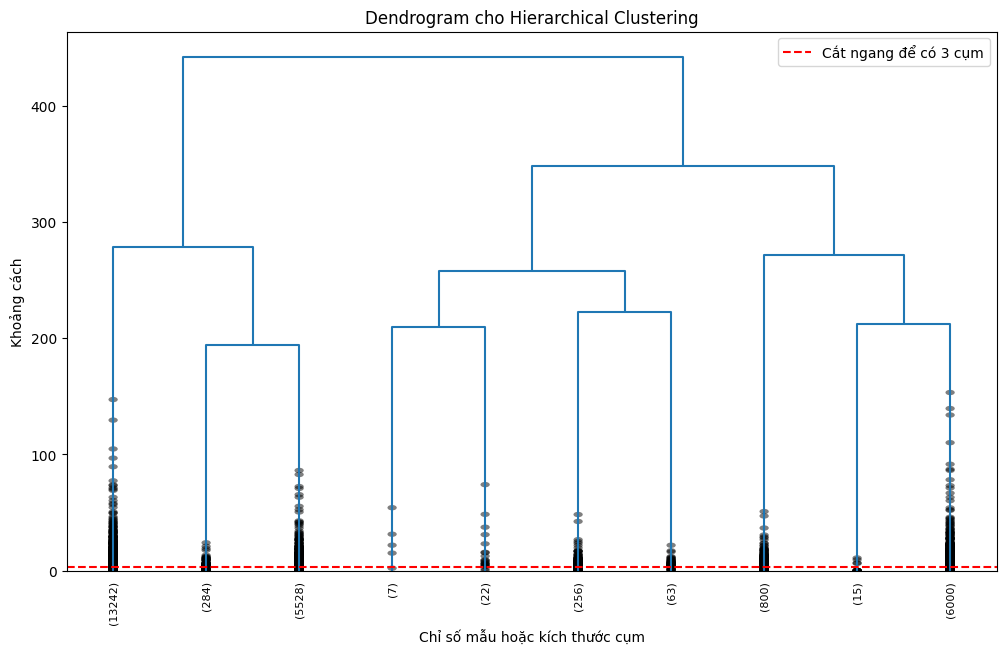

In [109]:
plt.figure(figsize=(12, 7))
dendrogram(linked_data,
           truncate_mode='lastp',  # Chỉ hiển thị p cụm cuối cùng ở mỗi nhánh
           p=10,                   # Số lượng cụm/điểm hiển thị ở cuối nhánh
           show_leaf_counts=True,
           leaf_rotation=90.,      # Xoay nhãn lá 90 độ
           leaf_font_size=8.,      # Kích thước font nhãn lá
           show_contracted=True,   # Hiển thị các nút rút gọn
           color_threshold=3.0     # Ngưỡng màu để trực quan hóa việc cắt
          )
plt.title('Dendrogram cho Hierarchical Clustering')
plt.xlabel('Chỉ số mẫu hoặc kích thước cụm')
plt.ylabel('Khoảng cách')
plt.axhline(y=3.0, color='r', linestyle='--', label='Cắt ngang để có 3 cụm')
plt.legend()
plt.show()

In [110]:
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_labels = agg_clustering.fit_predict(X_scaled)

In [112]:
print("Nhãn cụm từ Hierarchical Clustering (K=5, 10 điểm đầu tiên):")
print(hierarchical_labels[:10])
print(f"\nSilhouette Score cho Hierarchical Clustering (K=5): {silhouette_score(X_scaled, hierarchical_labels):.4f}")

Nhãn cụm từ Hierarchical Clustering (K=5, 10 điểm đầu tiên):
[2 3 2 2 2 2 2 2 2 2]

Silhouette Score cho Hierarchical Clustering (K=5): 0.1436
